In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


In [39]:
# ------------------------------
# Step 1: Load Data
# ------------------------------
import pandas as pd
import zipfile
import io

# Path to your ZIP files
train_zip_path = r"C:\Users\mandu\Downloads\Train-20250820T105340Z-1-001.zip"
test_zip_path = r"C:\Users\mandu\Downloads\Test-20250820T105339Z-1-001.zip"

# Method 1: Extract a specific file from the ZIP
with zipfile.ZipFile(train_zip_path, 'r') as z:
    # Choose which file you want to read from the ZIP
    # For example, let's read the orders.csv file
    with z.open('Train/orders.csv') as f:
        train = pd.read_csv(f)
        
with zipfile.ZipFile(test_zip_path, 'r') as z:
    # You'll need to know which file to extract from the test ZIP as well
    # For this example, I'm assuming there's a similar structure
    file_list = z.namelist()
    print("Files in test ZIP:", file_list)  # Print to see available files
    
    # Replace 'Test/test_file.csv' with the actual file you want from the test ZIP
    # This is just a placeholder - you'll need to use the correct filename
    test_file = [f for f in file_list if f.startswith('Test/')][0]  # Get first file
    with z.open(test_file) as f:
        test = pd.read_csv(f)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print(train.head())

# Alternative: If you want to extract all files first
# import os
# extract_dir = "extracted_data"
# os.makedirs(extract_dir, exist_ok=True)
# with zipfile.ZipFile(train_zip_path, 'r') as z:
#     z.extractall(extract_dir)
# train = pd.read_csv(os.path.join(extract_dir, "Train", "orders.csv"))

C:\Users\mandu\AppData\Local\Temp\ipykernel_26472\2794754822.py:17: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f)


Files in test ZIP: ['Test/test_customers.csv', 'Test/test_locations.csv']
Train shape: (135303, 26)
Test shape: (9768, 8)
   order_id customer_id  item_count  grand_total  payment_mode promo_code  \
0  163923.0     KL09J9N         6.0         10.1             1        NaN   
1  163924.0     H5LGGFX         3.0          8.4             1        NaN   
2  163925.0     CYLZB6T         4.0         15.0             1        NaN   
3  163929.0     4YKUKYN         7.0         27.2             1        NaN   
4  163930.0     WDNU30K         1.0          6.5             1        NaN   

   vendor_discount_amount  promo_code_discount_percentage is_favorite  \
0                     0.0                             NaN         NaN   
1                     0.0                             NaN         NaN   
2                     0.0                             NaN         NaN   
3                     0.0                             NaN         NaN   
4                     0.0                         

In [18]:
# Step 2: Standardize column names
# ------------------------------

train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

# Rename to standard names (edit if your columns are different)
train = train.rename(columns={"customer_id":"cid", "location":"loc_num", "vendor_id":"vendor"})
test = test.rename(columns={"customer_id":"cid", "location":"loc_num", "vendor_id":"vendor"})


Missing values in Train:
 order_id                              70
cid                                    0
item_count                          6925
grand_total                            0
payment_mode                           0
promo_code                        130998
vendor_discount_amount                 0
promo_code_discount_percentage     69423
is_favorite                        35195
is_rated                               0
vendor_rating                      90083
driver_rating                          0
deliverydistance                       0
preparationtime                    55560
delivery_time                     130180
order_accepted_time                48348
driver_accepted_time               88845
ready_for_pickup_time              51054
picked_up_time                     51438
delivered_time                     49562
delivery_date                      99759
vendor                                 0
created_at                             0
location_number               

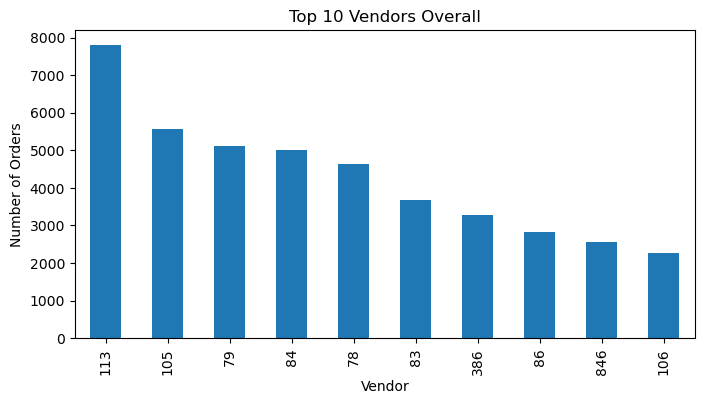


Top Vendors by Location:
     loc_num  vendor  count
27        0     113   7807
24        0     105   5562
14        0      79   5117


In [ ]:
# Step 3: EDA (Data Exploration)

import matplotlib.pyplot as plt  # Add this import statement for plotting

print("\nMissing values in Train:\n", train.isnull().sum())

# Top vendors overall
top_vendors = train["vendor"].value_counts().head(10)
print("\nTop Vendors:\n", top_vendors)

plt.figure(figsize=(8,4))
top_vendors.plot(kind="bar")
plt.title("Top 10 Vendors Overall")
plt.xlabel("Vendor")
plt.ylabel("Number of Orders")
plt.show()

# Top vendors by location
top_by_loc = train.groupby(["loc_num","vendor"]).size().reset_index(name="count")
top_by_loc = top_by_loc.sort_values(["loc_num","count"], ascending=[True,False])
print("\nTop Vendors by Location:\n", top_by_loc.groupby("loc_num").head(3))



In [25]:
# Step 4: Create Features
# ------------------------------

vendor_pop = train["vendor"].value_counts().to_dict()
loc_vendor_pop = train.groupby(["loc_num","vendor"]).size().to_dict()
user_vendor = train.groupby(["cid","vendor"]).size().to_dict()
user_loc = train.groupby(["cid","loc_num"]).size().to_dict()

def make_features(df):
    """Add numeric features"""
    df = df.copy()
    df["f_vendor_pop"] = df["vendor"].map(vendor_pop).fillna(0)
    df["f_loc_vendor_pop"] = df.apply(lambda r: loc_vendor_pop.get((r["loc_num"], r["vendor"]),0), axis=1)
    df["f_user_vendor"] = df.apply(lambda r: user_vendor.get((r["cid"], r["vendor"]),0), axis=1)
    df["f_user_loc"] = df.apply(lambda r: user_loc.get((r["cid"], r["loc_num"]),0), axis=1)
    return df

In [26]:
# Step 5: Build Training Data
# ------------------------------

# Positives
pos = train[["cid","loc_num","vendor"]].drop_duplicates()
pos["target"] = 1

# Negatives (sample vendors not ordered by user)
neg_samples = []
for row in pos.itertuples(index=False):
    cid, loc, ven, _ = row
    loc_vendors = [v for (l,v),cnt in loc_vendor_pop.items() if l==loc]
    for v in np.random.choice(loc_vendors, size=min(3, len(loc_vendors)), replace=False):
        if v != ven:
            neg_samples.append((cid,loc,v,0))

neg = pd.DataFrame(neg_samples, columns=["cid","loc_num","vendor","target"])

# Combine
train_pairs = pd.concat([pos, neg], ignore_index=True)

# Add features
train_feat = make_features(train_pairs)
X = train_feat[["f_vendor_pop","f_loc_vendor_pop","f_user_vendor","f_user_loc"]]
y = train_feat["target"]

In [27]:
# Step 6: Train/Validation Split
# ------------------------------

groups = train_feat["cid"]
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups))

X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

# Model
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200))
])
model.fit(X_train, y_train)

# Validation
val_pred = model.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, val_pred)
print("\nValidation AUC:", auc)


Validation AUC: 0.980827874128439


In [37]:
# Step 7: Predict on Test
# ------------------------------

# First, check if 'vendor' column exists in test data
if 'vendor' not in test.columns:
    # Add the missing column with a default value or handle it appropriately
    test['vendor'] = float('nan')

# Check if 'loc_num' column exists in test data
if 'loc_num' not in test.columns:
    # Add the missing 'loc_num' column
    # You might need to derive this value or use a default
    test['loc_num'] = float('nan')  # or some appropriate default value
    # If you know how to derive loc_num from other columns, do that instead

# Now create features
test_feat = make_features(test)
X_test = test_feat[["f_vendor_pop","f_loc_vendor_pop","f_user_vendor","f_user_loc"]]
test_feat["score"] = model.predict_proba(X_test)[:,1]

In [ ]:
submission = []
for (cid, loc), group in test_feat.groupby(["cid","loc_num"]):
    top_vendor = group.sort_values("score", ascending=False).iloc[0]
    for row in group.itertuples(index=False):
        target = 1 if row.vendor == top_vendor.vendor else 0
        submission.append(f"{row.cid} X {row.loc_num} X {row.vendor} {target}")

with open("submission.txt","w") as f:
    f.write("CID X LOC_NUM X VENDOR target\n")
    f.write("\n".join(submission))

print("\nSubmission file saved: submission.txt")

In [ ]:
with open("submission.txt","w") as f:
    f.write("CID X LOC_NUM X VENDOR target\n")
    f.write("\n".join(submission))

print("\nSubmission file saved: submission.txt")


In [ ]:
# Check submission file
with open("submission.txt","r") as f:
    lines = f.readlines()

print("✅ Submission File Preview:\n")
print("".join(lines[:15]))  # show first 15 lines


In [36]:
import os
import shutil

destination_path = os.path.join(os.path.expanduser('~'), 'Downloads')
shutil.copy('submission.txt', destination_path)
print(f"File copied to {os.path.join(destination_path, 'submission.txt')}")

File copied to C:\Users\mandu\Downloads\submission.txt
